# Experimenting with different NN architectures 

In [ ]:
%matplotlib inline

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


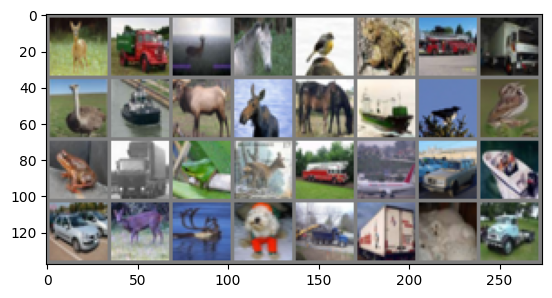

deer  truck deer  horse bird  frog  truck truck bird  ship  deer  deer  horse ship  bird  bird  frog  truck frog  deer  truck plane car   ship  car   deer  deer  dog   truck truck dog   truck


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, num_hidden_layers=2, num_filters=16, use_batch_norm=False):
        super(Net, self).__init__()
        self.use_batch_norm = use_batch_norm

        # First convolutional layer
        self.conv1 = nn.Conv2d(3, num_filters, 5)
        if self.use_batch_norm:
            self.bn1 = nn.BatchNorm2d(num_filters)

        self.pool = nn.MaxPool2d(2, 2)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(num_filters, num_filters * 2, 5)
        if self.use_batch_norm:
            self.bn2 = nn.BatchNorm2d(num_filters * 2)

        # Define hidden layers (fully connected layers)
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers - 2):
            self.hidden_layers.append(nn.Linear(num_filters * 2 * 5 * 5, num_filters * 2))
            if self.use_batch_norm:
                self.hidden_layers.append(nn.BatchNorm1d(num_filters * 2))

        # Fully connected layers
        self.fc1 = nn.Linear(num_filters * 2 * 5 * 5, 120)
        if self.use_batch_norm:
            self.bn_fc1 = nn.BatchNorm1d(120)

        self.fc2 = nn.Linear(120, 84)
        if self.use_batch_norm:
            self.bn_fc2 = nn.BatchNorm1d(84)

        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        if self.use_batch_norm:
            x = self.bn1(x)

        x = self.pool(F.relu(self.conv2(x)))
        if self.use_batch_norm:
            x = self.bn2(x)

        x = torch.flatten(x, 1)  # Flatten all dimensions except batch

        # Iterate through hidden layers
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                x = F.relu(layer(x))
            elif isinstance(layer, nn.BatchNorm1d):
                x = layer(x)

        x = F.relu(self.fc1(x))
        if self.use_batch_norm:
            x = self.bn_fc1(x)

        x = F.relu(self.fc2(x))
        if self.use_batch_norm:
            x = self.bn_fc2(x)

        x = self.fc3(x)
        return x

In [ ]:
import torch.optim as optim

# Define optimizers
optimizer_options = {
    'SGD': lambda params, lr: optim.SGD(params, lr=lr, momentum=0.9),
    'Adam': lambda params, lr: optim.Adam(params, lr=lr),
    'RMSprop': lambda params, lr: optim.RMSprop(params, lr=lr)
}

# Define learning rate schedulers
scheduler_options = {
    'None': None,
    'StepLR': lambda optimizer: optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1),
    'CosineAnnealingLR': lambda optimizer: optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
}

In [ ]:
# Define experiment configurations
experiment_configs = [
    {
        'num_hidden_layers': 2,
        'num_filters': 16,
        'learning_rate': 0.001,
        'scheduler': 'None',
        'optimizer': 'SGD',
        'use_batch_norm': False,
        'name': 'Exp1_SGD_NoBN_LR0.001_2HL_16F'
    },
    {
        'num_hidden_layers': 2,
        'num_filters': 16,
        'learning_rate': 0.001,
        'scheduler': 'StepLR',
        'optimizer': 'SGD',
        'use_batch_norm': False,
        'name': 'Exp2_SGD_StepLR_NoBN_LR0.001_2HL_16F'
    },
    {
        'num_hidden_layers': 3,
        'num_filters': 32,
        'learning_rate': 0.0005,
        'scheduler': 'CosineAnnealingLR',
        'optimizer': 'Adam',
        'use_batch_norm': True,
        'name': 'Exp3_Adam_CosAnneal_BN_LR0.0005_3HL_32F'
    },
    {
        'num_hidden_layers': 3,
        'num_filters': 32,
        'learning_rate': 0.001,
        'scheduler': 'StepLR',
        'optimizer': 'RMSprop',
        'use_batch_norm': True,
        'name': 'Exp4_RMSprop_StepLR_BN_LR0.001_3HL_32F'
    },
    # Add more configurations as needed to reach at least 10
    {
        'num_hidden_layers': 2,
        'num_filters': 32,
        'learning_rate': 0.0005,
        'scheduler': 'CosineAnnealingLR',
        'optimizer': 'Adam',
        'use_batch_norm': False,
        'name': 'Exp5_Adam_CosAnneal_NoBN_LR0.0005_2HL_32F'
    },
    {
        'num_hidden_layers': 3,
        'num_filters': 16,
        'learning_rate': 0.001,
        'scheduler': 'None',
        'optimizer': 'SGD',
        'use_batch_norm': True,
        'name': 'Exp6_SGD_NoSched_BN_LR0.001_3HL_16F'
    },
    {
        'num_hidden_layers': 2,
        'num_filters': 16,
        'learning_rate': 0.0005,
        'scheduler': 'StepLR',
        'optimizer': 'RMSprop',
        'use_batch_norm': True,
        'name': 'Exp7_RMSprop_StepLR_BN_LR0.0005_2HL_16F'
    },
    {
        'num_hidden_layers': 3,
        'num_filters': 32,
        'learning_rate': 0.001,
        'scheduler': 'CosineAnnealingLR',
        'optimizer': 'SGD',
        'use_batch_norm': False,
        'name': 'Exp8_SGD_CosAnneal_NoBN_LR0.001_3HL_32F'
    },
    {
        'num_hidden_layers': 2,
        'num_filters': 32,
        'learning_rate': 0.001,
        'scheduler': 'None',
        'optimizer': 'Adam',
        'use_batch_norm': True,
        'name': 'Exp9_Adam_NoSched_BN_LR0.001_2HL_32F'
    },
    {
        'num_hidden_layers': 3,
        'num_filters': 16,
        'learning_rate': 0.0005,
        'scheduler': 'StepLR',
        'optimizer': 'Adam',
        'use_batch_norm': False,
        'name': 'Exp10_Adam_StepLR_NoBN_LR0.0005_3HL_16F'
    }
]

In [ ]:
def train_model(net, trainloader, criterion, optimizer, scheduler=None, device='cpu', epochs=10):
    net.to(device)
    net.train()
    running_loss = 0.0
    for epoch in range(epochs):  # loop over the dataset multiple times
        start_time = time.time()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Optional: Step the scheduler after each batch
            if scheduler:
                scheduler.step()

            # Print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[Epoch {epoch +1}, Batch {i +1}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0
        end_time = time.time()
        print(f'Epoch {epoch +1} completed in {end_time - start_time:.2f} seconds.')
    print('Finished Training')

In [ ]:
def evaluate_model(net, testloader, device='cpu'):
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Per-class accuracy
            for label, prediction in zip(labels, predicted):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    overall_accuracy = 100 * correct / total
    print(f'Accuracy of the network on the 10000 test images: {overall_accuracy:.2f} %')

    # Per-class accuracy
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

    return overall_accuracy, correct_pred

In [ ]:
import pandas as pd

# Initialize a DataFrame to store results
results = pd.DataFrame(columns=['Experiment', 'Optimizer', 'Learning_Rate_Scheduler', 'Batch_Normalization',
                                'Hidden_Layers', 'Filters', 'Overall_Accuracy'])

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
for config in experiment_configs:
    try:
        print(f"\nStarting {config['name']}...")

        # Initialize the network with the current configuration
        net = Net(num_hidden_layers=config['num_hidden_layers'],
                  num_filters=config['num_filters'],
                  use_batch_norm=config['use_batch_norm'])

        # Define the loss function
        criterion = nn.CrossEntropyLoss()

        # Initialize the optimizer
        optimizer = optimizer_options[config['optimizer']](net.parameters(), lr=config['learning_rate'])

        # Initialize the scheduler if any
        scheduler = None
        if config['scheduler'] != 'None':
            scheduler = scheduler_options[config['scheduler']](optimizer)

        # Train the network
        train_model(net, trainloader, criterion, optimizer, scheduler, device=device, epochs=15)

        # Evaluate the network
        overall_acc, _ = evaluate_model(net, testloader, device=device)

        # Create a new DataFrame for the current experiment's result
        new_row = pd.DataFrame([{
            'Experiment': config['name'],
            'Optimizer': config['optimizer'],
            'Learning_Rate_Scheduler': config['scheduler'],
            'Batch_Normalization': config['use_batch_norm'],
            'Hidden_Layers': config['num_hidden_layers'],
            'Filters': config['num_filters'],
            'Overall_Accuracy': overall_acc
        }])

        # Concatenate the new row to the results DataFrame
        results = pd.concat([results, new_row], ignore_index=True)

        # Save results to a CSV file
        results.to_csv('experiment_results.csv', index=False)

        # Optionally, save the DataFrame as a pickle for later use
        results.to_pickle('experiment_results.pkl')

        # Optionally, save each trained model
        torch.save(net.state_dict(), f"./models/{config['name']}.pth")

    except Exception as e:
        print(f"Experiment {config['name']} failed with error: {e}")
    finally:
        # Free up memory
        del net
        torch.cuda.empty_cache()


Starting Exp1_SGD_NoBN_LR0.001_2HL_16F...
Epoch 1 completed in 15.51 seconds.
Epoch 2 completed in 19.12 seconds.
Epoch 3 completed in 16.04 seconds.
Epoch 4 completed in 17.43 seconds.
Epoch 5 completed in 17.25 seconds.
Epoch 6 completed in 17.14 seconds.
Epoch 7 completed in 15.81 seconds.
Epoch 8 completed in 17.57 seconds.
Epoch 9 completed in 16.02 seconds.
Epoch 10 completed in 16.30 seconds.
Epoch 11 completed in 16.54 seconds.
Epoch 12 completed in 16.63 seconds.
Epoch 13 completed in 15.63 seconds.
Epoch 14 completed in 17.08 seconds.
Epoch 15 completed in 15.64 seconds.
Finished Training
Accuracy of the network on the 10000 test images: 67.25 %
Accuracy for class: plane is 72.0 %
Accuracy for class: car   is 82.0 %
Accuracy for class: bird  is 65.6 %
Accuracy for class: cat   is 39.4 %
Accuracy for class: deer  is 59.5 %
Accuracy for class: dog   is 49.4 %
Accuracy for class: frog  is 80.6 %
Accuracy for class: horse is 75.9 %
Accuracy for class: ship  is 73.4 %
Accuracy fo